In [1]:
def modificar_geo(archivo_entrada, archivo_salida, nuevo_n, nuevo_r):
    with open(archivo_entrada, "r") as f:
        lineas = f.readlines()

    nuevas_lineas = []
    for linea in lineas:
        if linea.strip().startswith("n ="):
            nuevas_lineas.append(f"n = {nuevo_n};\n")
        elif linea.strip().startswith("r ="):
            nuevas_lineas.append(f"r = {nuevo_r};\n")
        elif "Transfinite Curve{1, 2}" in linea:
            nuevas_lineas.append(f"Transfinite Curve{{1, 2}} = {nuevo_n} Using Progression {nuevo_r};\n")
        elif "Transfinite Curve{4, 3}" in linea:
            nuevas_lineas.append(f"Transfinite Curve{{4, 3}} = {nuevo_n} Using Progression 1/{nuevo_r};\n")
        else:
            nuevas_lineas.append(linea)

    with open(archivo_salida, "w") as f:
        f.writelines(nuevas_lineas)

    print(f"Archivo guardado como '{archivo_salida}' con n = {nuevo_n} y r = {nuevo_r}")


In [2]:
modificar_geo("geo.geo", "geo.geo", nuevo_n=10, nuevo_r=1.3)

Archivo guardado como 'geo.geo' con n = 10 y r = 1.3


In [3]:
import gmsh
import meshio
from nodes import Node
from elements import CST
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

import gmsh
import meshio
from nodes import Node
from elements import CST

import gmsh
import meshio
from nodes import Node
from elements import CST
import numpy as np

def load_mesh_objects(geo_file="geo.geo", msh_file="mesh.msh"):
    gmsh.initialize()
    gmsh.open(geo_file)
    gmsh.model.mesh.generate(2)
    gmsh.write(msh_file)
    
    # Obtener el mapeo entre tag y nombre de entidades físicas
    physicals = gmsh.model.getPhysicalGroups()
    name_map = {}
    for dim, tag in physicals:
        name = gmsh.model.getPhysicalName(dim, tag)
        name_map[tag] = name

    gmsh.finalize()

    # Leer malla
    mesh = meshio.read(msh_file)
    nodes = [Node(i + 1, x, y) for i, (x, y, _) in enumerate(mesh.points)]

    # Crear elementos CST
    cst_elements = []
    for cell_block in mesh.cells:
        if cell_block.type == "triangle":
            for i, node_ids in enumerate(cell_block.data):
                cst_elements.append(CST(i + 1, list(node_ids + 1)))  # +1 base 1
            break

    # Detectar nodos en líneas físicas con nombre
    boundary_nodes = {name: set() for name in name_map.values() if name.startswith("Dirichlet")}
    
    for cell_block, phys_ids in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
        if cell_block.type == "line":
            for line, tag in zip(cell_block.data, phys_ids):
                phys_name = name_map.get(tag, None)
                if phys_name and phys_name.startswith("Dirichlet"):
                    for node_id in line:
                        boundary_nodes[phys_name].add(int(node_id) + 1)

    # Asignar etiquetas a los nodos
    for node in nodes:
        node.boundary_label = []
        for label, node_set in boundary_nodes.items():
            if node.id in node_set:
                node.boundary_label.append(label)

    print(f"{boundary_nodes=}")
    return nodes, cst_elements

nodes, elements = load_mesh_objects("geo.geo", "mesh.msh")

Info    : Reading 'geo.geo'...
Info    : Done reading 'geo.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000383542s, CPU 0.000392s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.000102959s, CPU 0.000106s)
Info    : 100 nodes 202 elements
Info    : Writing 'mesh.msh'...
Info    : Done writing 'mesh.msh'

boundary_nodes={'Dirichlet 1': {1, 2, 5, 6, 7, 8, 9, 10, 11, 12}, 'Dirichlet 2': {2, 3, 13, 14, 15, 16, 17, 18, 19, 20}, 'Dirichlet 3': {3, 4, 21, 22, 23, 24, 25, 26, 27, 28}, 'Dirichlet 4': {32, 33, 34, 35, 4, 36, 1, 29, 30, 31}}


In [4]:
def plot_mesh(nodes, elements, show_node_ids=False, show_elem_ids=False):
    x = np.array([node.x for node in nodes])
    y = np.array([node.y for node in nodes])

    # Convertir elementos CST a array de conectividades
    triangles = np.array([[nid - 1 for nid in elem.node_ids] for elem in elements])


    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')

    triang = Triangulation(x, y, triangles)
    ax.triplot(triang, color='gray', linewidth=0.8)

    if show_node_ids:
        for node in nodes:
            ax.text(node.x, node.y, str(node.id), color='blue', fontsize=8, ha='center', va='center')

    if show_elem_ids:
        for elem in elements:
            coords = np.array([[nodes[j - 1].x, nodes[j - 1].y] for j in elem.node_ids])

            centroid = coords.mean(axis=0)
            ax.text(*centroid, str(elem.id), color='red', fontsize=8, ha='center')

    ax.set_title("Mesh of triangular elements (CST)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    plt.tight_layout()
    plt.savefig("CST_mesh_plot.png", dpi=300)
    plt.show()


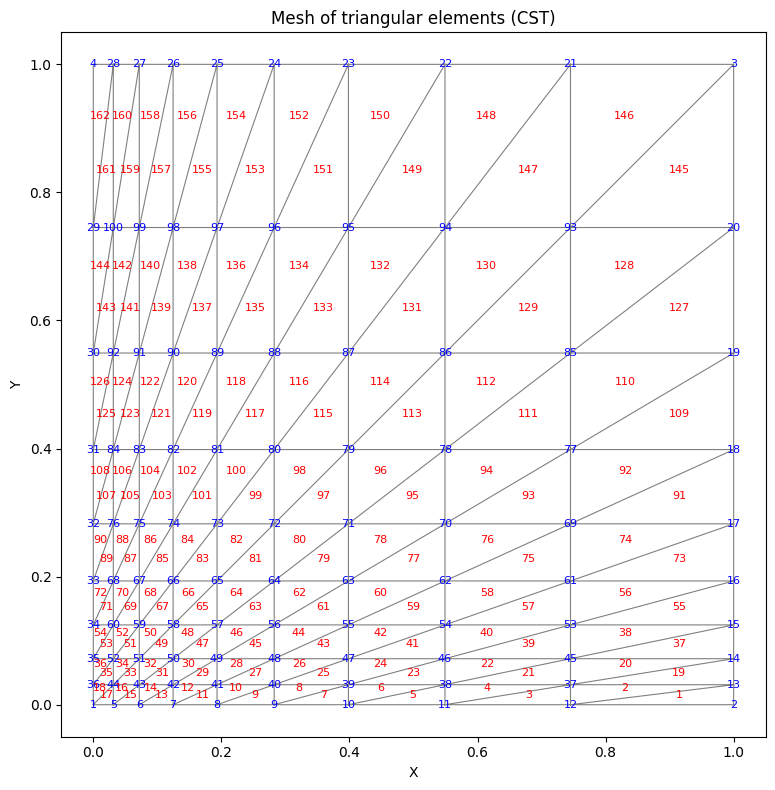

In [5]:

plot_mesh(nodes, elements, show_node_ids=True, show_elem_ids=True)


In [6]:
#Ahora debo calcular la solucion u
alpha = 3

for node in nodes:
    node.solve_u(alpha)

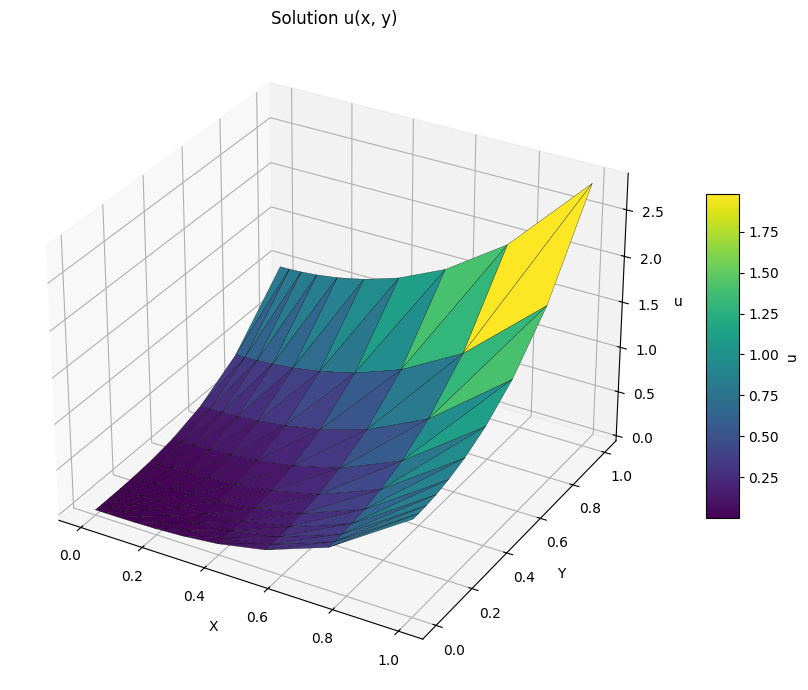

In [7]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.tri import Triangulation

def plot_u_surface_from_elements(nodes, elements, use_attr="u"):
    """
    Grafica una superficie 3D de u(x,y) usando la conectividad real de los elementos CST (base 1).
    """
    # Coordenadas de nodos
    x = np.array([node.x for node in nodes])
    y = np.array([node.y for node in nodes])
    z = np.array([getattr(node, use_attr) for node in nodes])  # puede ser node.u o node.u_fem

    # ⚠️ Convertir de base 1 → base 0
    triangles = np.array([[nid - 1 for nid in elem.node_ids] for elem in elements])

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    tri = Triangulation(x, y, triangles)
    surf = ax.plot_trisurf(tri, z, cmap='viridis', edgecolor='k', linewidth=0.2)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel(use_attr)
    ax.set_title(f"Solution {use_attr}(x, y)")

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label=use_attr)
    plt.tight_layout()
    plt.savefig(f"CST_{use_attr}_sol_surface_plot.png", dpi=300)
    plt.show()

plot_u_surface_from_elements(nodes, elements, use_attr="u")       # solución exacta



In [8]:
#Bien, ahora es nesesario ensamblar la stifnes matrix de cada elemento CST
from solve import Solve

Estructure = Solve(nodes, elements, alpha)



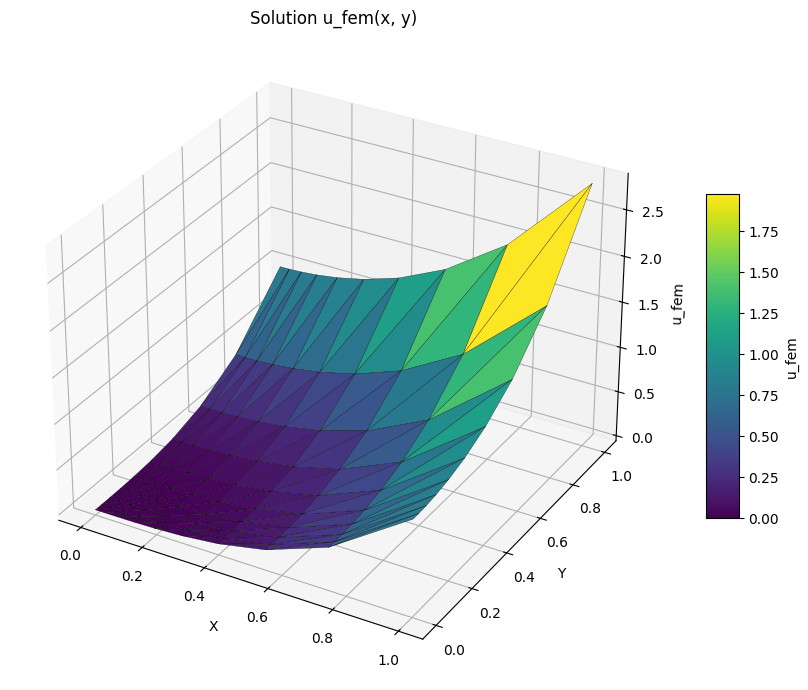

In [9]:
#Bien, ahora es nesesario calcular la solucion,
#Conozco todos lo que esta en la frontera diritchlet
Estructure.solve_matrix()
plot_u_surface_from_elements(nodes, elements, use_attr="u_fem")  # solución FEM



In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

def plot_relative_error_surface_3d(nodes, elements):
    """
    Grafica una superficie 3D (no interactiva) del error relativo entre u FEM y u exacto.
    """
    x = np.array([node.x for node in nodes])
    y = np.array([node.y for node in nodes])
    u_num = np.array([node.u_fem for node in nodes])
    u_ref = np.array([node.u for node in nodes])

    eps = 1e-14
    error_rel = np.abs(u_num - u_ref) / (np.abs(u_ref) + eps)

    # Usar conectividad real (base 1 → base 0)
    triangles = np.array([[nid - 1 for nid in elem.node_ids] for elem in elements])
    triang = Triangulation(x, y, triangles)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_trisurf(triang, error_rel, cmap='plasma', edgecolor='k', linewidth=0.2)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('Error relativo')
    ax.set_title('Relative Error Surface Plot (CST)')

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    plt.tight_layout()
    plt.savefig("CST_relative_error_surface_plot.png", dpi=300)
    plt.show()

    # Imprimir resumen numérico
    print(f"Máximo error relativo: {np.max(error_rel):.2e}")
    print(f"Promedio error relativo: {np.mean(error_rel):.2e}")
    print(f"Mínimo error relativo: {np.min(error_rel):.2e}")


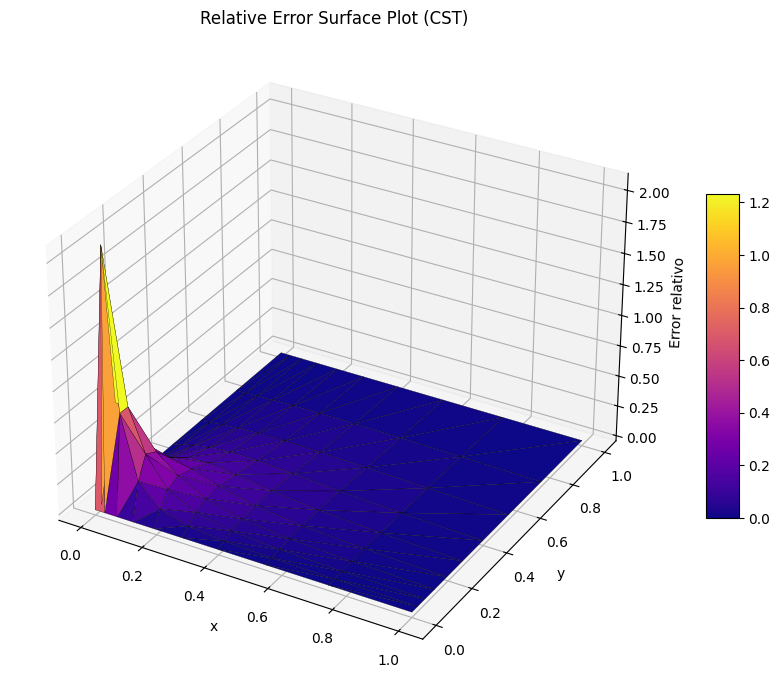

Máximo error relativo: 2.09e+00
Promedio error relativo: 1.02e-01
Mínimo error relativo: 0.00e+00


In [11]:
plot_relative_error_surface_3d(nodes, elements)


In [12]:
import numpy as np

def semi_norm_H1_0(alpha, orden=5):
    """
    Calcula |u|^2_{H^1_0(Ω)} = ∫_Ω |∇u(x,y)|² dxdy, donde u = (x² + y²)^{α/2},
    y Ω = [0,1] × [0,1] usando cuadratura de Gauss-Legendre.
    """
    puntos, pesos = np.polynomial.legendre.leggauss(orden)
    puntos = 0.5 * (puntos + 1)
    pesos = 0.5 * pesos

    total = 0.0

    for i in range(orden):
        for j in range(orden):
            x = puntos[i]
            y = puntos[j]
            w = pesos[i] * pesos[j]

            r2 = x**2 + y**2
            if r2 == 0 and alpha < 1:
                grad2 = 0.0  # evitar singularidad
            else:
                grad2 = alpha**2 * r2**(alpha - 1)

            total += grad2 * w

    return total  # ya es la semi-norma al cuadrado


result = semi_norm_H1_0(alpha, orden=5)
print(f"Resultado de |u|^2_{{H^1_0(Ω)}}: {result:.4f}")


Resultado de |u|^2_{H^1_0(Ω)}: 5.6000


In [13]:
from scipy.sparse import csr_matrix

fem_solution = Estructure.femm_solution()
print(f"Solución FEM (xᵀ K x): {fem_solution:.4f}")

Solución FEM (xᵀ K x): 5.6054
